# Model Prototyping

## Imports

In [ ]:
# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import os
from tqdm import tqdm

# Machine learning
from sklearn.model_selection import train_test_split

# PyTorch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

## Prototyping using huggingface transformers

In [1]:
from transformers import AutoTokenizer

/home/romain/miniconda3/envs/nlp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=True)

# INPUT TWEET IS ALREADY NORMALIZED!
line = "SC has first two presumptive cases of coronavirus , DHEC confirms HTTPURL via @USER :cry:"

input_ids = torch.tensor([tokenizer(line, padding="max_length", max_length=64, truncation=True).input_ids])


Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Let's check for how many tokens we'll need

In [ ]:
data = pd.read_csv("/content/data/train.csv")

In [ ]:
max = 0 
for text in data['text']:
  input_ids = tokenizer(text).input_ids
  max = np.max((max, len(input_ids)))

In [ ]:
print(max)

64


We can see the maximum number of tokens is 64, to take into account the fact that tweets from the test set may be longer, we'll set the max number of tokens to 90, this will speed the training.

In [ ]:
output = tokenizer.encode(line)
print(output)

[0, 4040, 90, 160, 255, 35006, 26940, 2612, 15, 1456, 7, 429, 6814, 499, 12952, 10, 156, 5, 22, 866, 22, 2]


In [ ]:
output_dict = tokenizer.encode_plus(line, add_special_tokens=True, max_length=90, padding='max_length', return_attention_mask=True, return_tensors='pt')
input_ids = output_dict.input_ids
attention_mask = output_dict.attention_mask

In [ ]:
input_ids

tensor([[    0,  4040,    90,   160,   255, 35006, 26940,  2612,    15,  1456,
             7,   429,  6814,   499, 12952,    10,   156,     5,    22,   866,
            22,     2,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]])

In [ ]:
attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
input_ids = []
attention_masks = []

tweets = data['text'].to_list()

for tweet in tweets:
  output_dict = tokenizer.encode_plus(tweet, add_special_tokens=True, max_length=90, padding='max_length', return_attention_mask=True, return_tensors='pt')
  input_ids.append(output_dict.input_ids)
  attention_masks.append(output_dict.attention_mask)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

labels = torch.tensor(data['target'].values)

In [ ]:
from torch.utils.data import TensorDataset, random_split, DataLoader

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.85 * len(dataset)) # 85 - 15 % split
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32 # Bigger values will increase the gradient precision, lower values will reduce the memory load

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels = 2, output_attentions = False, output_hidden_states = False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertForSequenceClassification: ['roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.self.key.bias', 'roberta.encoder.layer.4.output.dense.weight', 'roberta.embeddings.LayerNorm.weight', 'roberta.encoder.layer.5.attention.output.dense.bias', 'roberta.encoder.layer.8.attention.output.dense.bias', 'lm_head.decoder.bias', 'roberta.encoder.layer.10.output.LayerNorm.weight', 'roberta.encoder.layer.4.attention.output.dense.weight', 'roberta.encoder.layer.6.attention.output.dense.weight', 'roberta.encoder.layer.6.attention.self.value.bias', 'roberta.pooler.dense.bias', 'roberta.encoder.layer.5.intermediate.dense.weight', 'roberta.encoder.layer.8.attention.self.value.weight', 'roberta.encoder.layer.3.attention.output.dense.bias', 'roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.6.attention.outp

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, element

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, betas = (0.9, 0.999), eps = 1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs = 5):

  metrics = {
      "epochs" : [],
      "train_losses" : [],
      "val_losses" : [],
      "val_accs" : []
  }

  pbar = tqdm(range(epochs))

  for i, epoch in enumerate(pbar):
    model.train()

    total_train_loss = 0
    for i, batch in enumerate(train_dataloader):

      input_ids = batch[0].to(device)
      input_masks = batch[1].to(device)
      labels = batch[2].to(device)

      model.zero_grad()

      result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

      loss = result.loss
      logits = result.logits

      total_train_loss += loss.item()

      loss.backward()

      optimizer.step()

      scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    total_val_acc = 0
    total_val_loss = 0
    
    model.eval()
    for i, batch in enumerate(val_dataloader):

      input_ids = batch[0].to(device)
      input_masks = batch[1].to(device)
      labels = batch[2].to(device)

      with torch.no_grad():

        result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

      loss = result.loss
      logits = result.logits.detach().cpu().numpy()
      labels = labels.cpu().numpy()

      preds = np.argmax(logits, axis = 1).flatten()
      labels = labels.flatten()

      val_acc = np.sum(preds == labels) / len(labels)

      total_val_acc += val_acc
      total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_acc = total_val_acc / len(val_dataloader)

    metrics['epochs'].append(epoch + 1)
    metrics['train_losses'].append(avg_train_loss)
    metrics['val_losses'].append(avg_val_loss)
    metrics['val_accs'].append(avg_val_acc)
    
    pbar.set_postfix({'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'val_acc' : avg_val_acc})
  
  return model, metrics


100%|██████████| 5/5 [08:56<00:00, 107.34s/it, train_loss=0.028, val_loss=1.32, val_acc=0.749]


In [ ]:
metrics, model = train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs = epochs)

Text(0.5, 1.0, 'Accuracy')

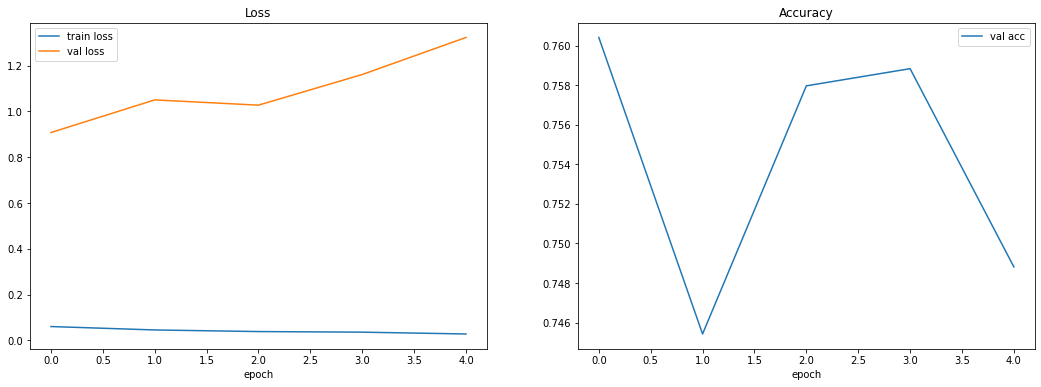

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)

plt.plot(metrics['train_losses'], label='train loss')
plt.plot(metrics['val_losses'], label='val loss')
plt.xlabel("epoch")
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(metrics['val_accs'], label='val acc')
plt.xlabel("epoch")
plt.legend()
plt.title('Accuracy')

At the moment, the model's training is not the best as the val loss is diverging from the train loss. Possible improvements :

* Use different lr scheduler
* Track the lr
* Use warmup
* Train on more epochs
* Compare approaches with optuna and wandb

## Try with data from tweets

In [ ]:
train_df = pd.read_csv('./train.csv')
train_df.head()

In [ ]:
print(train_df.loc[0, "text"])
input_ids = torch.tensor([tokenizer.encode(train_df.loc[0, "text"])])
text_decoded = tokenizer.decode(input_ids[0])
print(text_decoded)

In [ ]:
# Generate a tensor of all input ids with padding from tokenizer
encoded_input = tokenizer(list(train_df.text), add_special_tokens=True, padding=True, truncation=True)
input_ids = torch.tensor(encoded_input['input_ids'])
input_ids.shape

### Train, Val, Test split

In [ ]:
# Split data into train validaion and test
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
# Create train and validation dataset and dataloader
class DisasterTweetsDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        self.encoded_input = tokenizer(list(df.text), add_special_tokens=True, padding="max_length", max_length=64, truncation=True)
        self.input_ids = torch.tensor(self.encoded_input['input_ids'])
        self.labels = torch.tensor(df.target.values)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.labels[idx]

train_dataset = DisasterTweetsDataset(train_df, tokenizer)
val_dataset = DisasterTweetsDataset(val_df, tokenizer)
test_datset = DisasterTweetsDataset(test_df, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_datset, batch_size=32, shuffle=True)

In [ ]:
for batch in train_dataloader:
    inputs, labels = batch
    print(inputs.shape)
    print(labels.shape)
    break

In [ ]:
# train loop for the model
def train(model, train_dataloader, val_dataloader, epochs=10, lr=1e-5, device='cpu'):
    # Define loss function
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Define scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
    
    # Define metrics
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    pbar = tqdm(range(epochs), desc="Epochs", position=0, leave=True)

    for epoch, i in enumerate(pbar):
        # Training
        model.train()
        total_loss = 0
        total_correct = 0
        for batch in train_dataloader:
            # Get data
            input_ids, labels = batch
            input_ids = input_ids.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(input_ids) # (batch_size, 2)
            preds = torch.argmax(outputs, dim=1)

            loss = loss_fn(preds.float(), labels.float())
            loss.requires_grad = True

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Calculate accuracy
            total_correct += torch.sum(preds == labels)
            total_loss += loss.item()

        # Calculate average loss and accuracy
        avg_train_loss = (total_loss / len(train_dataloader))
        avg_train_acc = (total_correct.double() / len(train_dataloader)).item()
        metrics['train_loss'].append(avg_train_loss)
        metrics['train_acc'].append(avg_train_acc)

        # Validation
        model.eval()
        total_loss = 0
        total_correct = 0
        for batch in val_dataloader:
            # Get data
            input_ids, labels = batch
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)
            loss = loss_fn(preds.float(), labels.float()) 
            total_loss += loss.item()

            # Calculate accuracy
            total_correct += torch.sum(preds == labels)

        # Calculate average loss and accuracy
        avg_val_loss = (total_loss / len(val_dataloader))
        avg_val_acc = (total_correct.double() / len(val_dataloader)).item()
        metrics['val_loss'].append(avg_val_loss)
        metrics['val_acc'].append(avg_val_acc)

        # Update progress bar with val accuracy and train accuracy
        pbar.set_postfix({'train_acc': avg_train_acc, 'val_acc': avg_val_acc})

        # Update learning rate
        scheduler.step(avg_val_loss)

    # Plot loss and accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='train')
    plt.plot(metrics['val_loss'], label='val')
    plt.legend()
    plt.title('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='train')
    plt.plot(metrics['val_acc'], label='val')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

    return metrics, model

In [ ]:
# TODO : add progress bar, make sure what is logged in mettric is float and not tensor
# test loop for the model
def test(model, test_dataloader, device='cpu'):

    # Define loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    # Define metrics
    metrics = {
        'test_loss': [],
        'test_acc': []
    }

    # Test
    model.eval()
    total_loss = 0
    total_correct = 0
    for batch in tqdm(range(test_dataloader), desc="Testing", position=0, leave=True):
        # Get data
        input_ids, labels = batch
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1)
        loss = loss_fn(preds.float(), labels.float()) # outputs[0] is the logits
        total_loss += loss.item()

        # Calculate accuracy
        _, preds = torch.max(outputs[0], dim=1)
        total_correct += torch.sum(preds == labels)

    # Calculate average loss and accuracy
    avg_test_loss = total_loss / len(test_dataloader)
    avg_test_acc = (total_correct.double() / len(test_dataloader)).item()
    metrics['test_loss'].append(avg_test_loss)
    metrics['test_acc'].append(avg_test_acc)
    print(f"Test loss {avg_test_loss} accuracy {avg_test_acc}")

    return metrics

In [ ]:
# Create the model
bert_classifier = BERTweetClassifier(freeze_bert=False)

# Select device based on availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device used : {device}")
bert_classifier.to(device)

# train the model
metrics, model = train(bert_classifier, train_dataloader, val_dataloader, epochs=10, lr=1e-5, device=device)

In [ ]:
# test the model
test_metrics = test(model, test_dataloader, device=device)